In [1]:
# --- IMPORTS ---
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Define a function which will evaluate the model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Perform 10-fold cross-validation on the training set (using MAE and R2 metrics)
    mae_train = -cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
    r2_train = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

    # Fit on full training set and evaluate on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)

    # Return results
    return mae_train.mean(), r2_train.mean(), mae_test, r2_test

In [3]:
# Load data
data = pd.read_csv('steel.csv')
X = data.drop("tensile_strength", axis=1)
y = data["tensile_strength"]

# Create train/test split (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Setup 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

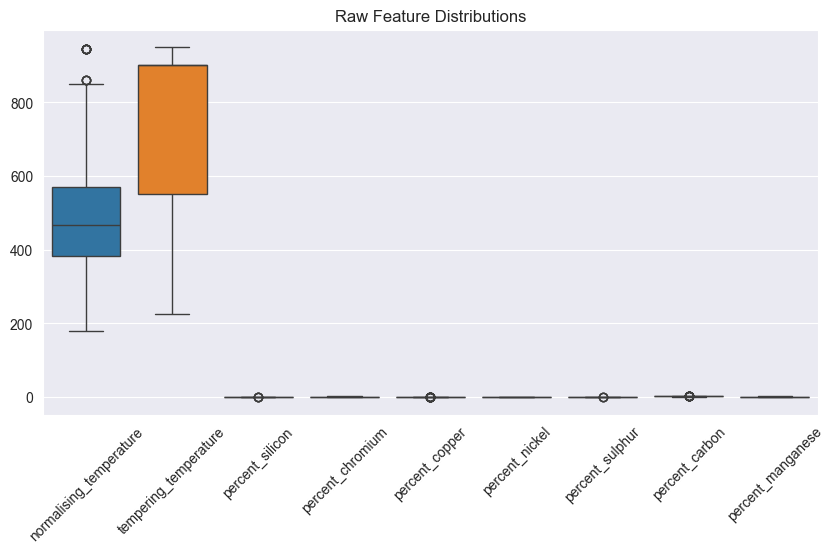

In [4]:
features = data.drop('tensile_strength', axis=1) # Drop prediction column, keep rest of features

# Create a boxplot to show raw feature distributions (no pre-processing)
plt.figure(figsize=(10,5))
sns.boxplot(data=features)
plt.title("Raw Feature Distributions")
plt.xticks(rotation=45)
plt.show()

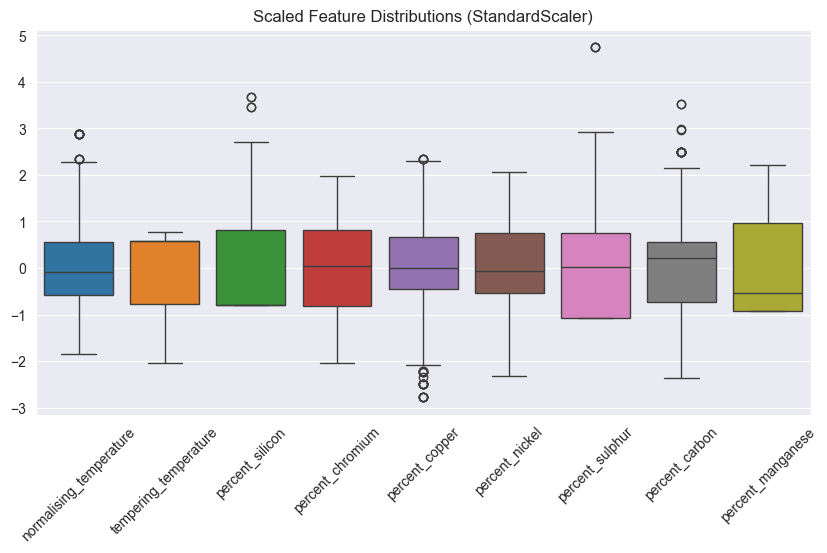

In [5]:
# Apply pre-processing (scale values of features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.drop('tensile_strength', axis=1))
X_scaled_df = pd.DataFrame(X_scaled, columns=data.columns[:-1])

# Create a boxplot to show feature distributions after pre-processing
plt.figure(figsize=(10,5))
sns.boxplot(data=X_scaled_df)
plt.title("Scaled Feature Distributions (StandardScaler)")
plt.xticks(rotation=45)
plt.show()

In [6]:
# Create default model (no hyperparameter tuning)
default_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Call model evaluation function and extract results into variables
default_mae_train, default_r2_train, default_mae_test, default_r2_test = evaluate_model(
    default_model, X_train, y_train, X_test, y_test
)

# Print out results for untuned model
print("=== DEFAULT DECISION TREE MODEL RESULTS ===")
print(f"Training MAE: {default_mae_train:.3f}, Training R²: {default_r2_train:.3f}")
print(f"Test     MAE: {default_mae_test:.3f}, Test     R²: {default_r2_test:.3f}")

=== DEFAULT DECISION TREE MODEL RESULTS ===
Training MAE: 32.783, Training R²: 0.709
Test     MAE: 27.605, Test     R²: 0.845


In [7]:
# Create grid for chosen hyperparameters
param_grid = {
    'regressor__max_depth': [3, 5, 7, 9, None],
    'regressor__max_features': ['sqrt', 'log2', 0.5, 0.8, None]
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Create tuned model #1 (with GridSearchCV for hyperparameter tuning)
# -> This one will be used for the main results and MAE heatmap
tuned_model_mae = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
# Fit the GridSearchCV on the training data
tuned_model_mae.fit(X_train, y_train)

# Create tuned model #2 (with GridSearchCV for hyperparameter tuning)
# -> This one will be used for the R2 heatmap only
tuned_model_r2 = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=-1
)
# Fit the GridSearchCV on the training data
tuned_model_r2.fit(X_train, y_train)

# Extract the best performing MAE model into variable
best_mae_model = tuned_model_mae.best_estimator_

# Call model evaluation function with best performing MAE model and extract results into variables
tuned_mae_train, tuned_r2_train, tuned_mae_test, tuned_r2_test = evaluate_model(
    best_mae_model, X_train, y_train, X_test, y_test
)

# Print out results for tuned model
print("\n=== TUNED DECISION TREE MODEL RESULTS ===")
print("Best hyperparameters:", tuned_model_mae.best_params_)
print(f"Training MAE: {tuned_mae_train:.3f}, Training R²: {tuned_r2_train:.3f}")
print(f"Test     MAE: {tuned_mae_test:.3f}, Test     R²: {tuned_r2_test:.3f}")


=== TUNED DECISION TREE MODEL RESULTS ===
Best hyperparameters: {'regressor__max_depth': None, 'regressor__max_features': 0.8}
Training MAE: 29.817, Training R²: 0.753
Test     MAE: 26.380, Test     R²: 0.849


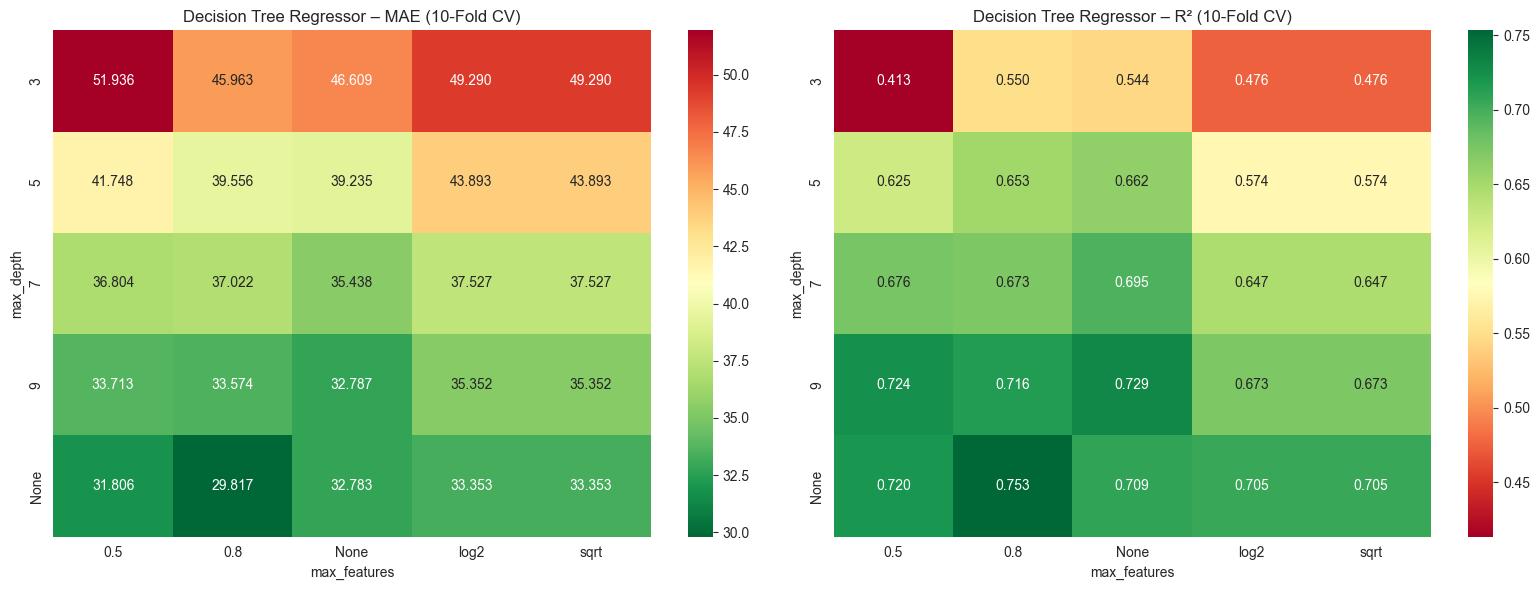

In [8]:
# Create MAE results dataframe
results_mae = pd.DataFrame(tuned_model_mae.cv_results_)

results_mae = results_mae[[
    'param_regressor__max_depth',
    'param_regressor__max_features',
    'mean_test_score'
]]

# Convert to string for cleaner labels
results_mae['param_regressor__max_depth'] = results_mae['param_regressor__max_depth'].astype(str)
results_mae['param_regressor__max_features'] = results_mae['param_regressor__max_features'].astype(str)

# Convert negative MAE to positive
results_mae['MAE'] = -results_mae['mean_test_score']

# Pivot table for heatmap
heatmap_mae = results_mae.pivot(
    index='param_regressor__max_depth',
    columns='param_regressor__max_features',
    values='MAE'
)

# Create R² results dataframe
results_r2 = pd.DataFrame(tuned_model_r2.cv_results_)

results_r2 = results_r2[[
    'param_regressor__max_depth',
    'param_regressor__max_features',
    'mean_test_score'
]]

# Convert to string for cleaner labels
results_r2['param_regressor__max_depth'] = results_r2['param_regressor__max_depth'].astype(str)
results_r2['param_regressor__max_features'] = results_r2['param_regressor__max_features'].astype(str)

# Pivot table for heatmap
heatmap_r2 = results_r2.pivot(
    index='param_regressor__max_depth',
    columns='param_regressor__max_features',
    values='mean_test_score'
)

# Plot both heatmaps side-by-side
plt.figure(figsize=(16, 6))

# MAE heatmap
plt.subplot(1, 2, 1)
sns.heatmap(heatmap_mae, annot=True, fmt=".3f", cmap='RdYlGn_r')
plt.title("Decision Tree Regressor – MAE (10-Fold CV)")
plt.xlabel("max_features")
plt.ylabel("max_depth")

# R² heatmap
plt.subplot(1, 2, 2)
sns.heatmap(heatmap_r2, annot=True, fmt=".3f", cmap='RdYlGn')
plt.title("Decision Tree Regressor – R² (10-Fold CV)")
plt.xlabel("max_features")
plt.ylabel("max_depth")

plt.tight_layout()
plt.show()